In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import lec8_graphs as afx
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,20)
plt.style.use('ggplot')

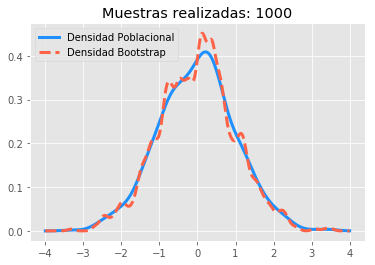

In [4]:
afx.plot_bootstrap(n_sims=1000)

In [6]:
df = pd.read_csv('cadata.csv', header=1).drop(columns = '1')
df['log_MedianHouseValue'] = np.log(df['MedianHouseValue'])
df['log_MedianIncome'] = np.log(df['MedianIncome'])
df = df.drop(columns=['MedianHouseValue','MedianIncome'])

In [8]:
from sklearn.model_selection import train_test_split
X_train , X_test ,y_train, y_test = train_test_split(df.loc[:,'MedianHouseAge':'log_MedianIncome'],
                                                     df['log_MedianHouseValue'],test_size=.33 , random_state=11238)

In [9]:
from sklearn.ensemble import BaggingRegressor

In [10]:
bagging_model = BaggingRegressor(random_state=11238).fit(X_train,y_train)

In [11]:
for i in bagging_model.estimators_:
    print("Modelo: {}. Criterio: {}. Semilla {}".format(type(i), i.criterion, i.random_state))

Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 134534932
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 1532576145
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 1982095898
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 280845846
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 1572358144
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 198602398
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 120741769
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 860188809
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 2093968571
Modelo: <class 'sklearn.tree.tree.DecisionTreeRegressor'>. Criterio: mse. Semilla 1518121755


In [12]:
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [14]:
print("Test MSE: ", mean_squared_error(y_test,bagging_model.predict(X_test)))
print("Test MAE: ", median_absolute_error(y_test,bagging_model.predict(X_test)))
print("Test R2: ", r2_score(y_test,bagging_model.predict(X_test)))

Test MSE:  3.230931987572375e-05
Test MAE:  8.32986303915817e-05
Test R2:  0.9999018710019694


In [15]:
X_test[:1]

,MedianHouseAge,TotalRooms,TotalBedrooms,Population,Households,Latitude,Longitude,log_MedianHouseValue,log_MedianIncome
16934,9.0,1150.0,287.0,377.0,243.0,37.56,-122.32,12.377923,1.343309


In [16]:
y_test[:1]

16934    12.377923
Name: log_MedianHouseValue, dtype: float64

In [18]:
hold_instance = [i.predict(X_test[:1]) for i in bagging_model.estimators_]

In [19]:
dec_tree_lab = ['Regression Tree: {}'.format(i+1) for i in range(len(bagging_model.estimators_))]

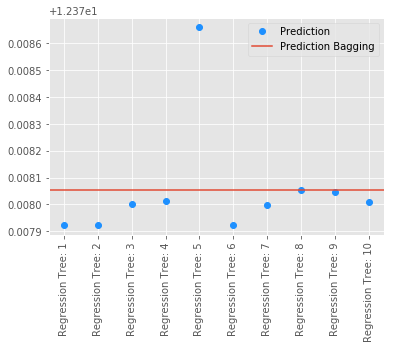

In [22]:
plt.plot(hold_instance, 'o', color = 'dodgerblue', label='Prediction')
plt.xticks(range(10), dec_tree_lab, rotation=90)
plt.axhline(bagging_model.predict(X_test[:1]), label='Prediction Bagging')
plt.legend()

In [24]:
tmp_mse_test , tmp_mae_test, tmp_r2_test = [] , [], []

n_tree = range(20,1000,50)

for i in n_tree:
    tmp_bad_model = BaggingRegressor(n_estimators=i, random_state=11238).fit(X_train, y_train)
    tmp_mse_test.append(mean_squared_error(y_test,tmp_bad_model.predict(X_test)))
    tmp_mae_test.append(median_absolute_error(y_test,tmp_bad_model.predict(X_test)))
    tmp_r2_test.append(r2_score(y_test,tmp_bad_model.predict(X_test)))

In [25]:
params = [[1, tmp_r2_test, r2_score(y_test,tmp_bad_model.predict(X_test)), 'r2'],
          [2, tmp_mse_test, mean_squared_error(y_test,tmp_bad_model.predict(X_test)), 'mse'],
          [3, tmp_mae_test, median_absolute_error(y_test,tmp_bad_model.predict(X_test)), 'mae']]

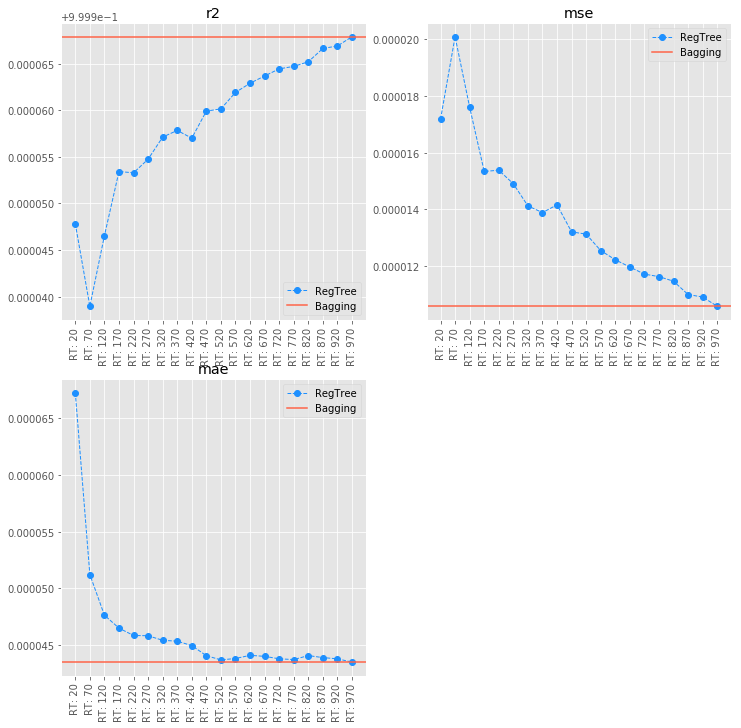

In [27]:
plt.figure(figsize=(12,12))

for i in params:
    plt.subplot(2,2,i[0])
    afx.plot_bagging_behavior(i[1],i[2], n_tree)
    plt.title(str(i[3]))
    plt.tight_layout

In [28]:
from scipy import stats
import seaborn as sns
store_rho = []

bag_est = bagging_model.estimators_

for i in bag_est:
    for j in bag_est:
        store_rho.append(stats.pearsonr(i.predict(X_test), j.predict(X_test))[0])
        
store_rho = np.array(store_rho).reshape(len(bag_est), len(bag_est))

Text(0.5, 1.0, 'Correlacion bivariadas entre arboles')

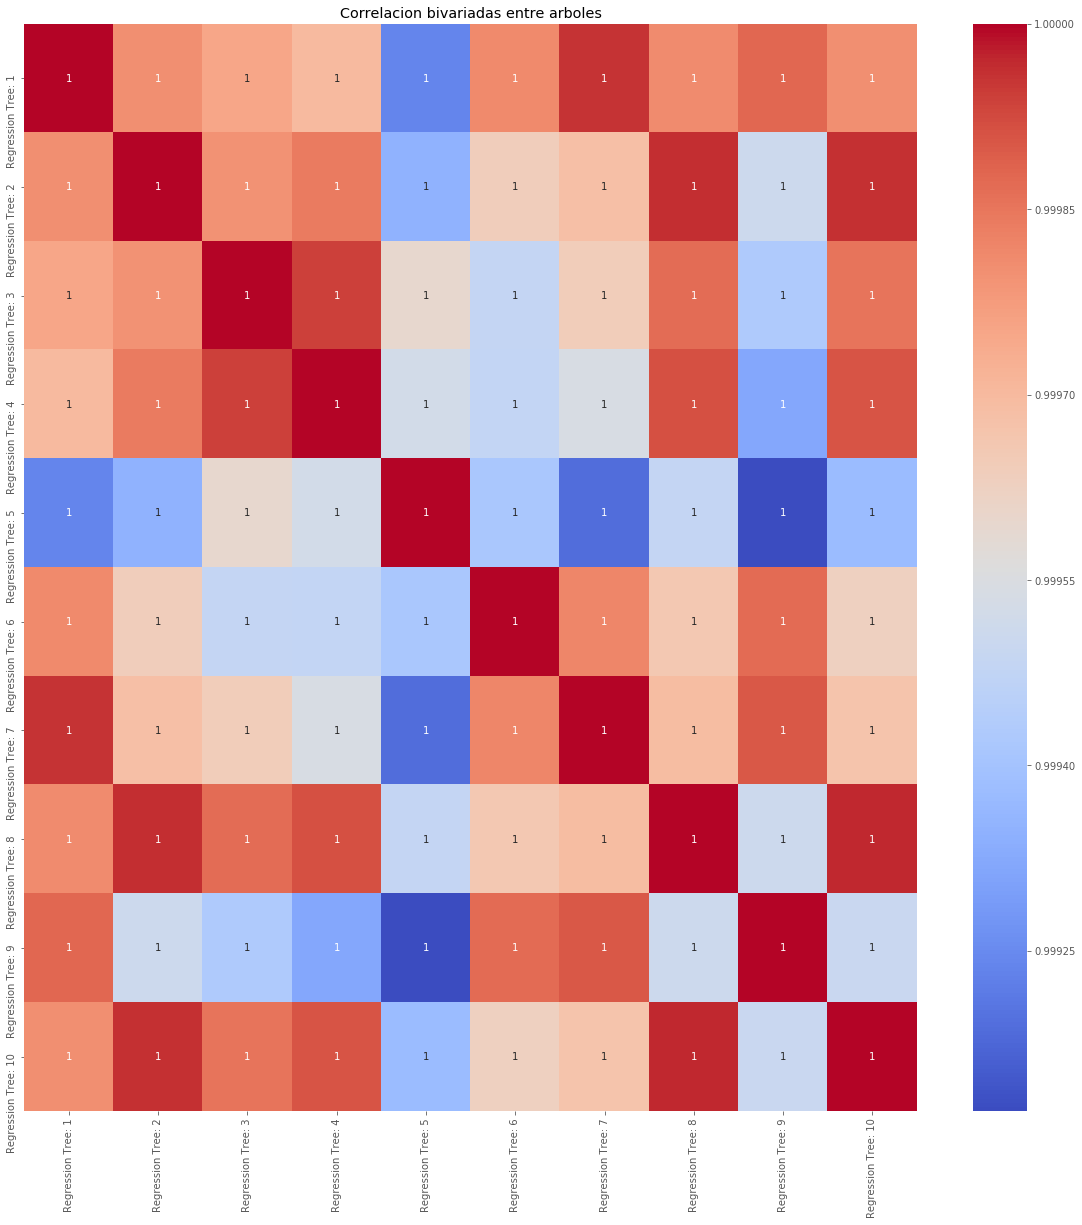

In [30]:
plt.figure(figsize=(20,20))
sns.heatmap(store_rho,cmap='coolwarm',annot=True, xticklabels=dec_tree_lab, yticklabels=dec_tree_lab)
plt.title('Correlacion bivariadas entre arboles')

In [61]:
df = pd.read_csv('voting.csv').drop(columns='Unnamed: 0')
df = pd.concat([df, pd.get_dummies(df['region'], drop_first=True, prefix='region')], axis=1)
df = pd.concat([df, pd.get_dummies(df['education'], drop_first=True, prefix='ed')], axis=1)
df = pd.concat([df, pd.get_dummies(df['sex'], drop_first=True, prefix='sex')], axis=1)
df = pd.concat([df, pd.get_dummies(df['vote'], drop_first=True, prefix='vote')], axis=1)
df = df.drop(columns=['region','education','sex','vote'])
df.head()
df = df.dropna()
X_train , X_test, y_train , y_test = train_test_split(df.loc[:,'population':'sex_M'], df['vote_N'], test_size=.33, random_state=11238)

In [62]:
df.head()

,population,age,income,statusquo,region_M,region_N,region_S,region_SA,ed_PS,ed_S,sex_M,vote_N,vote_U,vote_Y
0,175000,65.0,35000.0,1.00820,0,1,0,0,0,0,1,0,0,1
1,175000,29.0,7500.0,-1.29617,0,1,0,0,1,0,1,1,0,0
2,175000,38.0,15000.0,1.23072,0,1,0,0,0,0,0,0,0,1
3,175000,49.0,35000.0,-1.03163,0,1,0,0,0,0,0,1,0,0
4,175000,23.0,35000.0,-1.10496,0,1,0,0,0,1,0,1,0,0


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report

In [64]:
voting_rf = RandomForestClassifier(oob_score = True, random_state=11238).fit(X_train,y_train)

C:\Users\s4056291\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\s4056291\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\s4056291\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [65]:
len(voting_rf.estimator_params)

10

In [66]:
print(classification_report(y_test, voting_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       572
           1       0.75      0.63      0.69       283

   micro avg       0.81      0.81      0.81       855
   macro avg       0.79      0.76      0.78       855
weighted avg       0.81      0.81      0.80       855



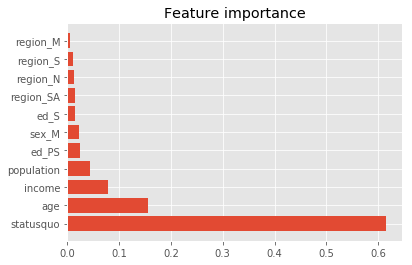

In [67]:
x_mat_vars = df.loc[:,'population':'sex_M']
afx.plot_importance(voting_rf, x_mat_vars.columns)

Text(0, 0.5, 'Status Quo')

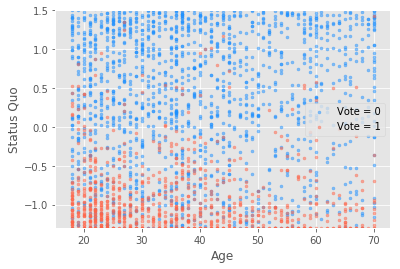

In [71]:
depured_X = df.loc[:,['age','statusquo','vote_N']]
colors = ['dodgerblue','tomato']

for i in depured_X['vote_N'].unique():
    plt.scatter(depured_X[depured_X['vote_N'] == i]['age'],
               depured_X[depured_X['vote_N'] == i]['statusquo'],
               marker='.',label='Vote = {}'.format(i), alpha=.5 ,color=colors[i])
                
plt.legend()
plt.ylim(-1.3,1.5);
plt.xlabel('Age')
plt.ylabel('Status Quo')

In [72]:
random_forest = RandomForestClassifier(n_estimators=500,n_jobs=-1,
                                       random_state=11238,oob_score=True).fit(depured_X.loc[:,'age':'statusquo'],
                                                                              depured_X['vote_N'])
get_x_1 = afx.fetch_lims(depured_X['statusquo'])
get_x_2 = afx.fetch_lims(depured_X['age'])
x_mesh , y_mesh , joint_xy = afx.generate_mesh_grid(depured_X, 'age','statusquo')
Z = random_forest.predict_proba(np.c_[x_mesh.ravel(),y_mesh.ravel()])[:,1].reshape(x_mesh.shape)


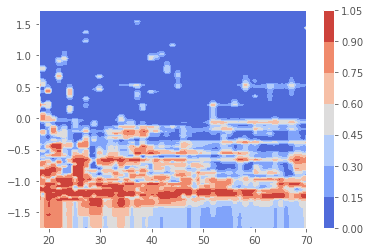

In [73]:
plt.contourf(x_mesh,y_mesh,Z,cmap='coolwarm')
plt.colorbar()

In [75]:
tmp_oob_none, tmp_oob_sqrt , tmp_oob_log2 = [],[],[]
tmp_test_acc_none , tmp_test_acc_sqrt, tmp_test_acc_log2 = [],[],[]
n_stimators = range(20,1000,25)

In [77]:
for i in n_stimators:
    voting_rf_none = RandomForestClassifier(n_estimators=i,max_features=None, oob_score=True,random_state=123).fit(X_train,y_train)
    voting_rf_sqrt = RandomForestClassifier(n_estimators=i,max_features='sqrt', oob_score=True,random_state=123).fit(X_train,y_train)
    voting_rf_log2 = RandomForestClassifier(n_estimators=i,max_features='log2', oob_score=True,random_state=123).fit(X_train,y_train)
    tmp_oob_none.append(1 - voting_rf_none.oob_score_)
    tmp_oob_sqrt.append(1 - voting_rf_sqrt.oob_score_)
    tmp_oob_log2.append(1 - voting_rf_log2.oob_score_)
    tmp_test_acc_none.append(1 - accuracy_score(y_test, voting_rf_none.predict(X_test)))
    tmp_test_acc_sqrt.append(1 - accuracy_score(y_test, voting_rf_sqrt.predict(X_test)))
    tmp_test_acc_log2.append(1 - accuracy_score(y_test, voting_rf_log2.predict(X_test)))
    

<Figure size 864x720 with 0 Axes>

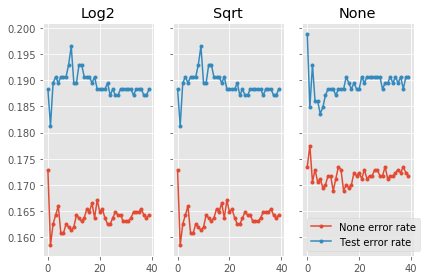

In [80]:
plt.figure(figsize=(12,10));
fig, axs = plt.subplots(1,3,sharex=True,sharey=True)
axs[0].plot(tmp_oob_log2,'.-', label='OOB error rate');
axs[0].plot(tmp_test_acc_log2,'.-', label='Test error rate');
axs[0].set_title('Log2');

axs[1].plot(tmp_oob_sqrt,'.-', label='Sqrt error rate');
axs[1].plot(tmp_test_acc_sqrt,'.-', label='Test error rate');
axs[1].set_title('Sqrt');

axs[2].plot(tmp_oob_none,'.-', label='None error rate');
axs[2].plot(tmp_test_acc_none,'.-', label='Test error rate');
axs[2].set_title('None');
plt.tight_layout();
plt.legend();